# R0 track
from https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb


Using Bayes rule

$$
\text{P}\left( R_t | k \right) = \frac{\text{P}\left( k | R_t \right) \cdot \text{P}\left( R_t \right)}{\text{P}\left( k \right)}
$$

This shows that given $k$ new cases we believe the distribution of $R_t$ is equal to 
- the **likelihood** of $k$ new cases given $R_t$ times
- the **prior** expectation of $P(R_t)$ without any data divided by
- the probability of seeing $k$ new cases

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTER_REGION_CODES = ['AS', 'GU', 'PR', 'VI', 'MP']
%config InlineBackend.figure_format = 'retina'

## choosing a likelihood function $\text{P}\left( k_t | R_t \right)$

For new 'arrivals' we use the **Poissson** distribution,  if we are expecting $\lambda$ new cases a day, the distribution function for $k$ is

$$
\text{P}\left( k | \lambda \right) = \frac{\lambda^k e^{- \lambda}}{k !}
$$

In [2]:
k = np.arange(0, 70)[:, None]  # column vector
lambdas = [10, 20, 30, 40]

y = sps.poisson.pmf(k, lambdas)

print(y.shape)

(70, 4)


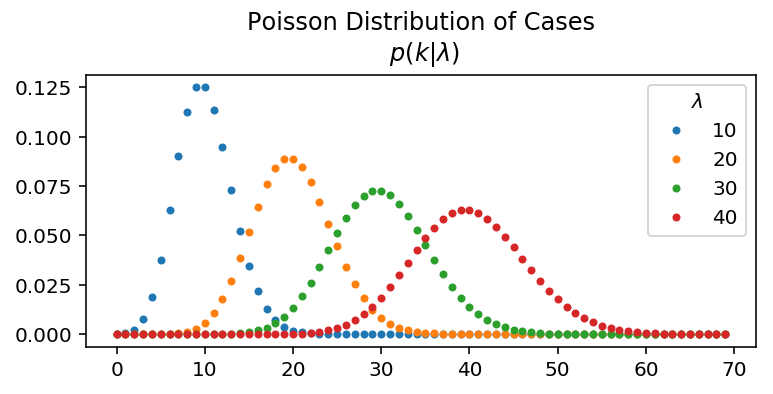

In [3]:
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')
plt.plot(k, y, marker='o', markersize=3, lw=0)
plt.legend(title='$\lambda$', labels=lambdas)
plt.show()

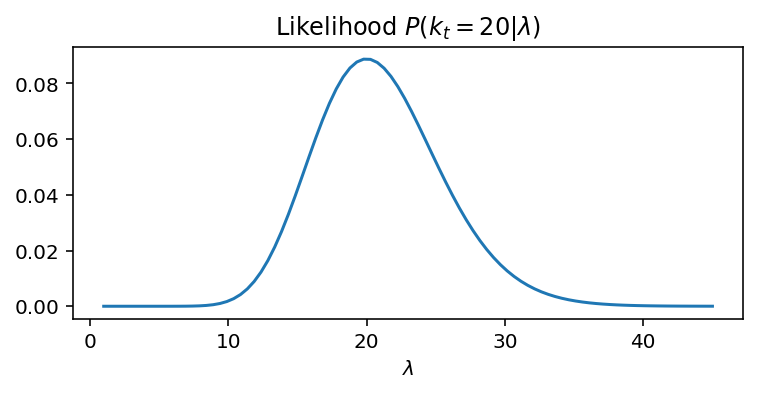

In [4]:
k = 20
lam = np.linspace(1, 45, 90)
likelihood = pd.Series(data=sps.poisson.pmf(k, lam), index=pd.Index(lam, name='$\lambda$'), name='lambda')
likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$', figsize=(6, 2.5))
plt.show()

Next we follow the work of

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185

and extrapolate a **connection between $R_t$ and $\lambda$**.

Given by
$$
\lambda = k_{t-1}e^{\gamma ( R_t - 1)}
$$
where $\gamma$ is the **reciprocol of the serial interval**

Let us now fix $k$ and vary $R_t$ (we know that every new case count on the previous day)

$$
\text{P}\left(k | R_t \right) = \frac{\lambda^k e^{-\lambda}}{k!}
$$

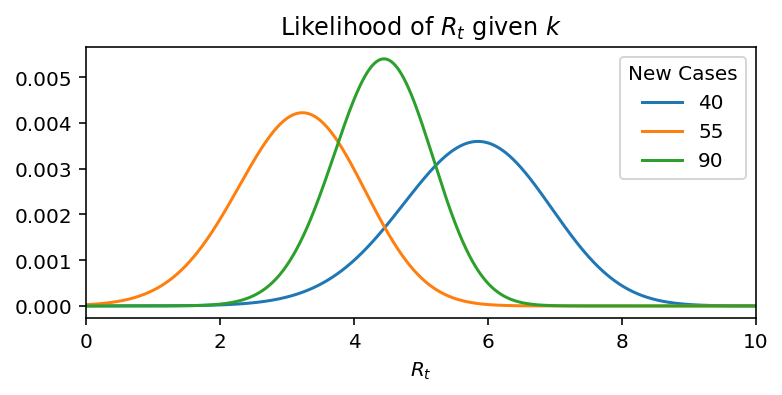

In [5]:
k = np.array([20, 40, 55, 90])
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)  # 100 steps

GAMMA = 1/7 #1/Serial Interval
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

ax = pd.DataFrame(data=likelihood_r_t, index=r_t_range).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10),
    figsize=(6, 2.5)
)
ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$')
plt.show()

the above graph is showing that $90$ new cases gives the strongest likelihood around $4.5$; while $40$ new cases implices the $R_t$ is more likely to be around $6$.

## perform the Bayesian update
multiply the likelihood by the prior (which is previous day's likelihood wihtout our Gaussian update) to get the posteriors. Do that using the cumulative product of each successive day

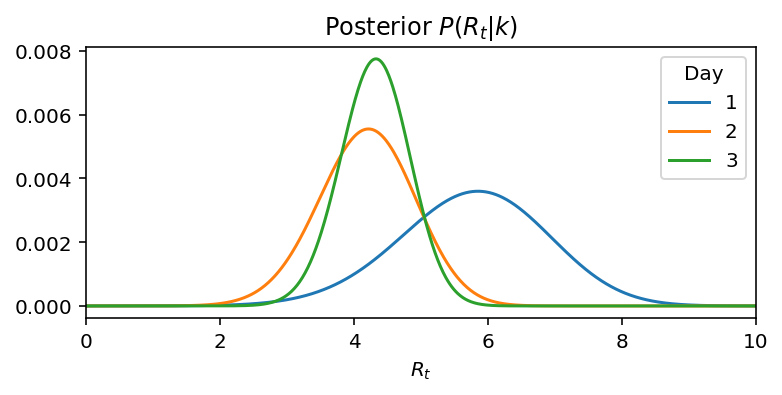

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(data=posteriors, index=r_t_range, columns=columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$')
plt.show()

In [7]:
# what is the most likley number for each day?
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

In [8]:
# let's makea  function to get these confidence intervals
def highest_density_interval(pmf, p=.9):
    if isinstance(pmf, pd.DataFrame):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf], index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    total_p = cumsum - cumsum[:, None] # N x N matrix of total prob mass for each low, high
    
    lows, highs = (total_p > p).nonzero()
    best = (highs - lows).argmin()
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


In [9]:
highest_density_interval(posteriors, p=.8)

,Low_80,High_80
Day,,
1,4.32,7.17
2,3.21,5.06
3,3.59,4.92


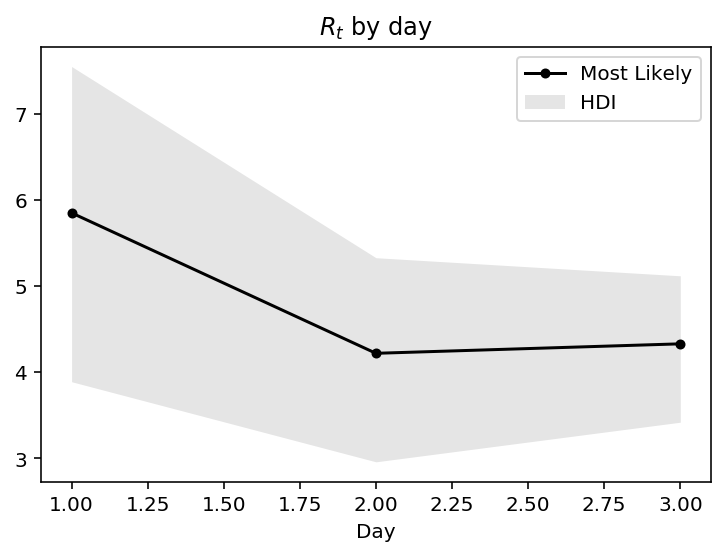

In [10]:
# go ahead and plot the expected R_t and 90percent interval
ax = most_likely_values.plot(
    marker='o',
    label='Most Likely',
    title=f'$R_t$ by day',
    c='k',
    markersize=4
)

ax.fill_between(
    hdi.index,
    hdi['Low_90'],
    hdi['High_90'],
    color='k',
    alpha=.1,
    lw=0,
    label='HDI'
)

ax.legend()
plt.show()

# Real Data
Use the US state data from COVID Tracking

In [11]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
# 25 columns - current hosp and inclu
states = pd.read_csv(
    url,
    usecols=['date', 'state', 'positive'],   # hospitalized
    parse_dates=['date'],
    index_col=['state', 'date'],
    squeeze=True
).sort_index()
states.head()

state  date      
AK     2020-03-06    0.0
       2020-03-07    0.0
       2020-03-08    0.0
       2020-03-09    0.0
       2020-03-10    0.0
Name: positive, dtype: float64

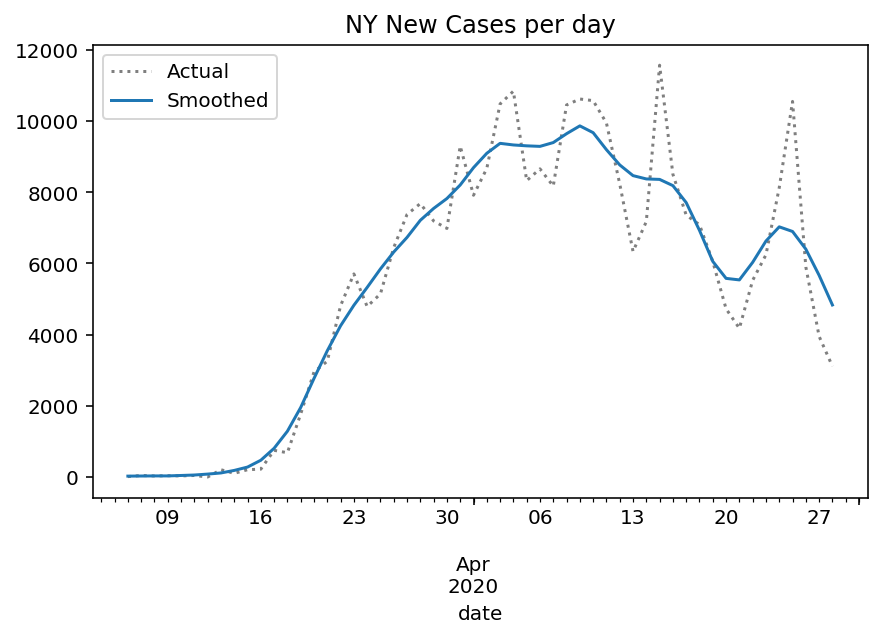

In [40]:
# lets use a gaussian filter to normalize over the reporting dates
#  if I could get data from the onset on a case by case that would be best

def prep_cases(cases, cutoff=25):
    new_cases = cases.diff()
    smoothed = new_cases.rolling(
        7,
        win_type='gaussian',
        min_periods=1,
        center=True
    ).mean(std=2).round()
    
    idx_start = int(np.searchsorted(smoothed, cutoff))
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    return original, smoothed

cases = states.xs('NY').rename(f'NY Cases')
original, smoothed = prep_cases(cases)

# plot them both
original.plot(
    title='NY New Cases per day',
    c='k',
    linestyle=':',
    alpha=.5,
    label='Actual',
    legend=True,
    figsize=(500/72, 300/72)
)
ax = smoothed.plot(label='Smoothed', legend=True)
ax.get_figure().set_facecolor('w')
plt.show()

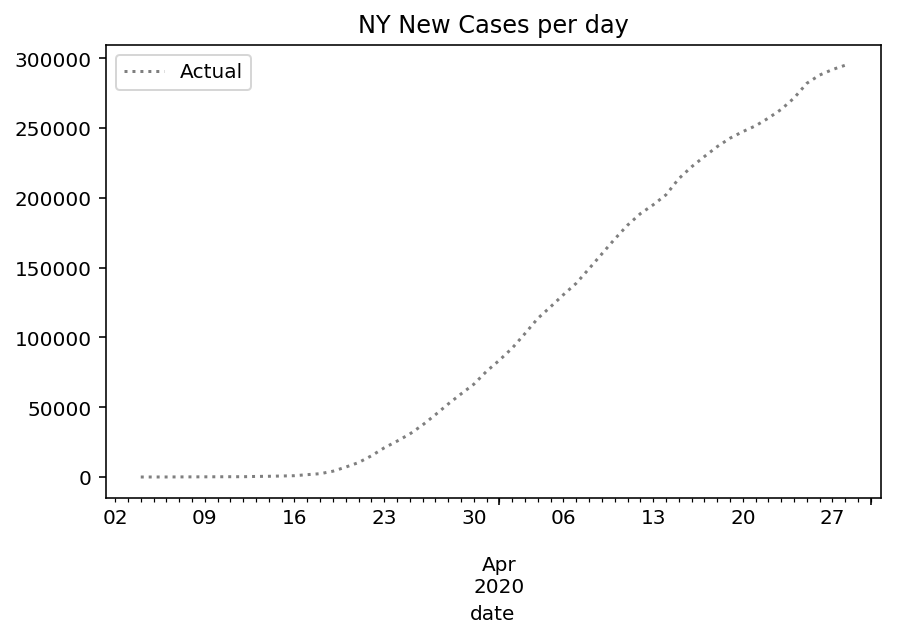

In [41]:
cases = states.xs('NY').rename(f'NY Cases')

cases.plot(
    title='NY New Cases per day',
    c='k',
    linestyle=':',
    alpha=.5,
    label='Actual',
    legend=True,
    figsize=(500/72, 300/72)
)
plt.show()